In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

In [2]:
## load dataset and cleaning
lib = pd.read_csv("SPARK.csv")
sample = pd.read_csv("project.csv")
Richter = pd.read_csv("Richter.csv")
Davis = pd.read_csv("Davis.csv")
Iyer = pd.read_csv("Iyer.csv")
Drugs = pd.read_csv("Drugs.csv")

lib = lib.drop(columns='pKa', axis=1).dropna()
labels = lib.columns[1:]

sample = sample.drop(columns='bpKa1', axis=1)
Richter = Richter.drop(columns='bpKa1', axis=1)
Davis = Davis.drop(columns='bpKa1', axis=1)
Iyer = Iyer.drop(columns='bpKa1', axis=1)
Drugs = Drugs.drop(columns='bpKa1', axis=1).dropna()

In [3]:
## filter out molecules that have molecular weight outside 200-1500 (too small or too big)
def filter(df):
    return df[(df.iloc[:,1] >= 200) & (df.iloc[:,1] <= 1500)]

lib = filter(lib)
Drugs = filter(Drugs)

Richter = filter(Richter)
Davis = filter(Davis)
Iyer = filter(Iyer)

sample = filter(sample)

In [4]:
## scale features
scaler = StandardScaler()
scaler.fit(lib.iloc[:,1:])

Tlib = scaler.transform(lib.iloc[:,1:])
TDrugs = scaler.transform(Drugs.iloc[:,1:])

TRichter = scaler.transform(Richter.iloc[:,1:])
TDavis = scaler.transform(Davis.iloc[:,1:])
TIyer = scaler.transform(Iyer.iloc[:,1:])

Tsample = scaler.transform(sample.iloc[:,1:])

In [5]:
## PCA
pca = PCA(n_components=2).fit(Tlib)
coeff = np.transpose(pca.components_)

pca_l = pca.transform(Tlib)
pca_Dr = pca.transform(TDrugs)

pca_R = pca.transform(TRichter)
pca_Da = pca.transform(TDavis)
pca_I = pca.transform(TIyer)

pca_s = pca.transform(Tsample)

In [6]:
## draw boundaries around datapoints
from scipy.spatial import ConvexHull

def draw_scatter_w_boundary(points, label, marker, color, linewidth=1):
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], color=color, alpha=0.8, linewidth=linewidth)
    plt.scatter(points[:,0], points[:,1], label=label, s=80, alpha=0.6, marker=marker, c=color, linewidths=3)
    return

## 1. Distribution plot

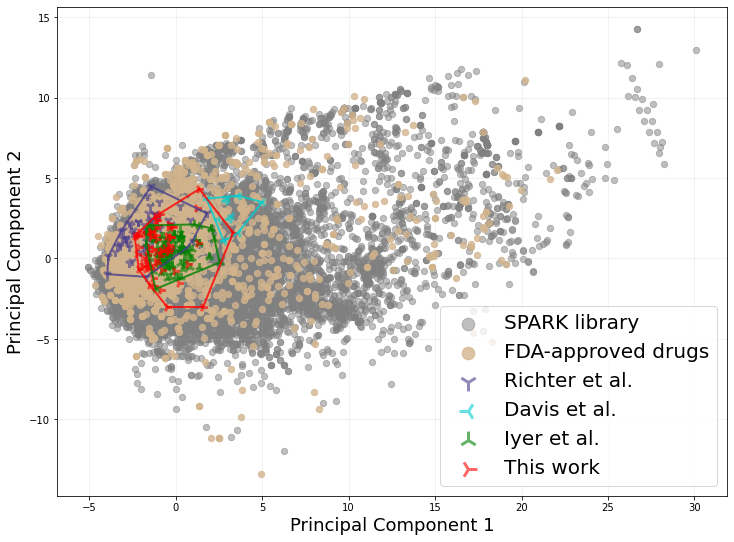

In [7]:
plt.figure(figsize=(12,9))

plt.scatter(pca_l[:,0], pca_l[:,1], label="SPARK library", s=40, alpha=0.5, c="gray")
plt.scatter(pca_Dr[:,0], pca_Dr[:,1], label="FDA-approved drugs", s=40, alpha=0.8, c="tan")

draw_scatter_w_boundary(pca_R, "Richter et al.", "1", "darkslateblue", 2)
draw_scatter_w_boundary(pca_Da, "Davis et al.", "3", "darkturquoise", 2)
draw_scatter_w_boundary(pca_I, "Iyer et al.", "2", "green", 2)
draw_scatter_w_boundary(pca_s, "This work", "4", "red", 2)

plt.xlabel("Principal Component 1", fontdict={'size':'18'})
plt.ylabel("Principal Component 2", fontdict={'size':'18'})

lgnd = plt.legend(markerscale=2, labelspacing=0.5, loc=4, fontsize=20)

plt.grid(zorder=-1.0, alpha=0.2)

plt.show()

## 2.Loading plot

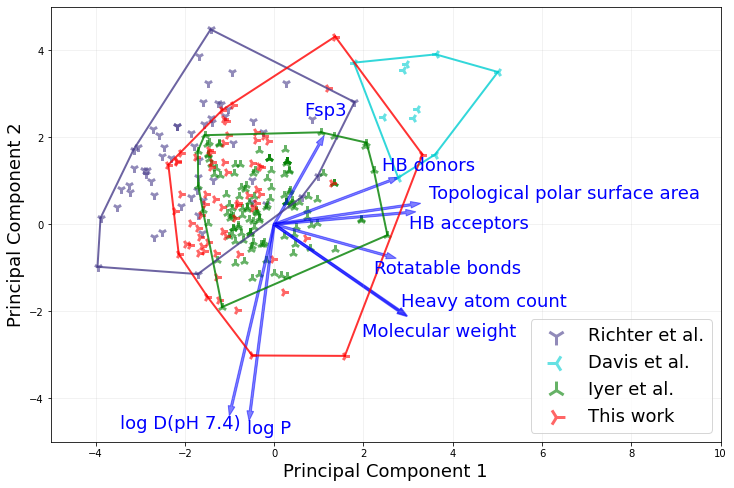

In [15]:
plt.figure(figsize=(12,8))

plt.xlim((-5, 10))
plt.ylim((-5, 5))

draw_scatter_w_boundary(pca_R, "Richter et al.", "1", "darkslateblue", 2)
draw_scatter_w_boundary(pca_Da, "Davis et al.", "3", "darkturquoise", 2)
draw_scatter_w_boundary(pca_I, "Iyer et al.", "2", "green", 2)
draw_scatter_w_boundary(pca_s, "This work", "4", "red", 2)

plt.legend(markerscale=2, labelspacing=0.5, loc=4, fontsize=18)
plt.grid(zorder=-1.0, alpha=0.2)

plt.xlabel("Principal Component 1", fontdict={'size':'18'})
plt.ylabel("Principal Component 2", fontdict={'size':'18'})

# ['Molecular weight', 'log P', 'HB donors', 'HB acceptors','log D(pH 7.4)', 'Topological polar surface area', 'Fsp3','Heavy atom count', 'Rotatable bonds']
XY_correction = [(0.5,-0.2),(0.5,0.2),(0.5,0.2),(1,-0.3),(-1,0.2),(3,0.2),(0,0.5),(1.5,0.5),(1,-0.2)]

for i in range(coeff.shape[0]):
    plt.arrow(0, 0, coeff[i,0]*7, coeff[i,1]*7, color='b', width=0.05, alpha=0.5)
    plt.text(coeff[i,0]*8+XY_correction[i][0], coeff[i,1]*8+XY_correction[i][1], labels[i], color='b', ha='center', va='center', size=18)

plt.show()

## 3.Violin plot (not shown in publication)

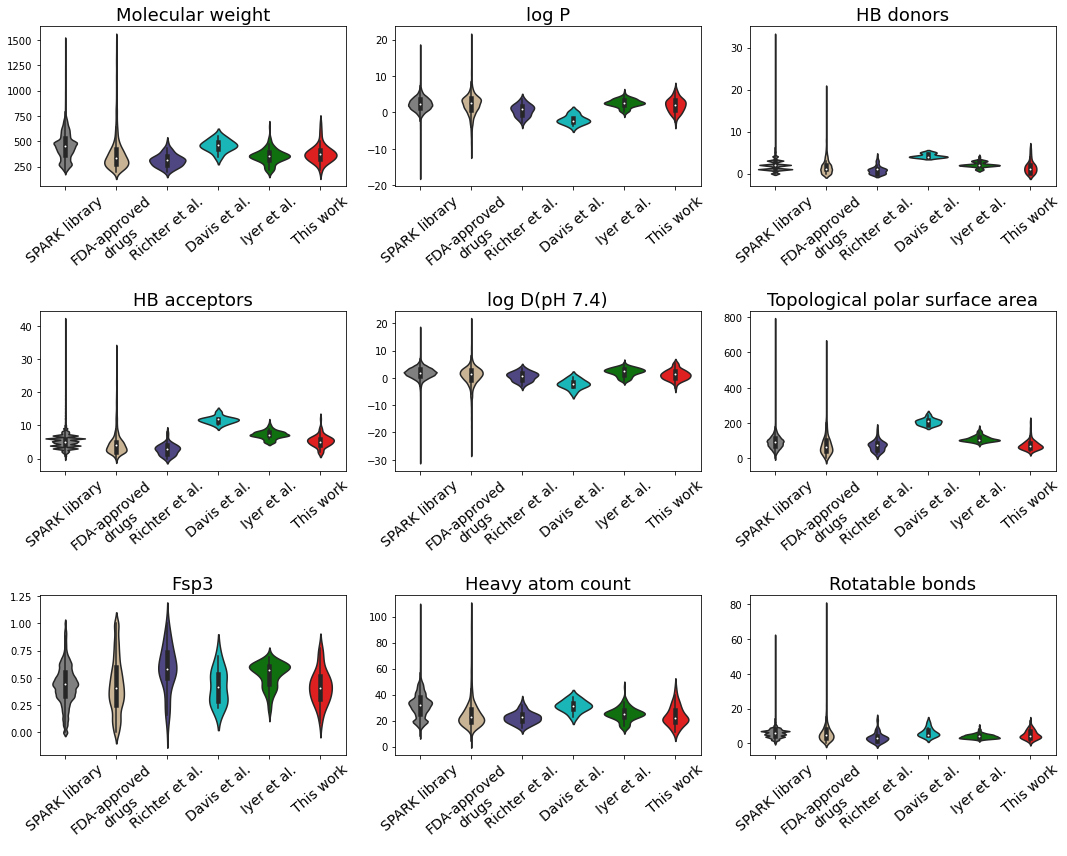

In [16]:
import seaborn as sns

sources = ("SPARK library", "FDA-approved\ndrugs", "Richter et al.", "Davis et al.", "Iyer et al.", "This work")
Colors = ("gray", "tan", "darkslateblue", "darkturquoise", "green", "red")

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,12))

for i, ax in enumerate(axes.reshape(-1)):
    sns.violinplot(data=(lib.iloc[:,i+1], Drugs.iloc[:,i+1], Richter.iloc[:,i+1], Davis.iloc[:,i+1], Iyer.iloc[:,i+1], sample.iloc[:,i+1]), palette=Colors, ax=ax)
    ax.set_title(labels[i], fontsize=18)
    ax.set_xticks(range(6))
    ax.set_xticklabels(sources, fontsize=14, rotation=40)

fig.tight_layout()
plt.show()